# European Airbnb Listing Price Analysis - a Project Proposal

## Introduction

Europe is the most traveled region in the world (UNWTO, 2023) and there are many countries to explore. In order to have the most enjoyable trip, proper planning and budgeting is required. Airbnb is one of the most popular ways to find accommodation while you travel. Hence, we would like to determine what factors determine the price of an Airbnb listing in ten most popular European cities, how strongly they affect Airbnb listing prices, and build a model that predicts the price given properties about the listing. We will use the dataset(s) from a study published in Tourism Management titled, “Determinants of Airbnb prices in European cities: A spatial econometrics approach”. These datasets are separated by city and type of day and includes the price and type of listing (shared or entire home), maximum capacity of rental, and cleanliness rating, among other factors.

## Preliminary Exploratory Data Analysis

In [14]:
library(tidyverse)
library(tidymodels)
# Cities are, amsterdam, athens, barcelona, berlin, budapest, lisbon, london, paris, rome, vienna, days are weekdays, weekends
url_first <- "https://zenodo.org/record/4446043/files/"
cities <- c("amsterdam", "athens", "barcelona", "berlin", "budapest", "lisbon", "london", "paris", "rome", "vienna");
total_dataset <- tibble()

for (i in 1:10) {
    sub_data <- read_csv(paste(url_first, cities[i], "_weekdays.csv", sep ="")) |>
        mutate(city = cities[i]) |>
        mutate(day = "weekday")
    Sys.sleep(0.5) # don't overload their server
    sub_data_end <- read_csv(paste(url_first, cities[i], "_weekends.csv", sep ="")) |>
        mutate(city = cities[i]) |>
        mutate(day = "weekend")
    total_dataset <- bind_rows(total_dataset, sub_data, sub_data_end)
    Sys.sleep(0.5) # don't overload their server
}

New names:
• `` -> `...1`
Rows: 1103 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 977 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 2653 Columns: 20
── Column specification ──────────────────

In [2]:
# clean data
airbnb_clean <- total_dataset |>
    select(-1) |> #some incrementing number
# according to https://zenodo.org/record/4446043#.Y9Y9ENJBwUE these columns are dummies:
    select(-room_private, -room_shared) |>
# apparently these are already scaled to [0,100] - drop the duplicate
    select(-attr_index, -rest_index) |>
    mutate(room_type = as_factor(room_type)) |>
    mutate(city = as_factor(city), day = as_factor(day)) |>
    rename(dist_from_city_centre = dist,
           cost = realSum,
           attraction_index = attr_index_norm,
           restaurant_index = rest_index_norm)

airbnb_clean |>
    select(room_type) |>
    pull() |>
    levels()

glimpse(airbnb_clean)

[1] "Private room"    "Entire home/apt" "Shared room"

Rows: 51,707
Columns: 17
$ cost                       <dbl> 194.0337, 344.2458, 264.1014, 433.5294, 485…
$ room_type                  <fct> Private room, Private room, Private room, P…
$ person_capacity            <dbl> 2, 4, 2, 4, 2, 3, 2, 4, 4, 2, 2, 2, 4, 2, 2…
$ host_is_superhost          <lgl> FALSE, FALSE, FALSE, FALSE, TRUE, FALSE, FA…
$ multi                      <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1…
$ biz                        <dbl> 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ cleanliness_rating         <dbl> 10, 8, 9, 9, 10, 8, 10, 10, 9, 10, 10, 10, …
$ guest_satisfaction_overall <dbl> 93, 85, 87, 90, 98, 100, 94, 100, 96, 88, 9…
$ bedrooms                   <dbl> 1, 1, 1, 2, 1, 2, 1, 3, 2, 1, 1, 1, 1, 1, 1…
$ dist_from_city_centre      <dbl> 5.0229638, 0.4883893, 5.7483119, 0.3848620,…
$ metro_dist                 <dbl> 2.5393800, 0.2394039, 3.6516213, 0.4398761,…
$ attraction_index           <dbl> 4.166708, 33.421209, 3.985908, 26.119108, 2…
$ restaurant_in

In [3]:
airbnb_split <- initial_split(airbnb_clean, prop = 0.75, strata = room_type)
airbnb_train <- training(airbnb_split)
airbnb_test <- testing(airbnb_split)

In [15]:
airbnb_train |>
    select(-room_type, -city, -day) |>
    map_df(mean)

airbnb_train |>
    select(room_type) |>
    group_by(room_type) |>
    summarize(counts = length(room_type))

airbnb_train |>
    select(-room_type, -city, -day) |>
    cor()

cost,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist_from_city_centre,metro_dist,attraction_index,restaurant_index,lng,lat
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
279.7686,3.160731,0.2560406,0.2921427,0.3495964,9.398334,92.69638,1.16135,3.183022,0.6805778,13.41364,22.76414,7.404743,45.66946


room_type,counts
<fct>,<int>
Private room,14017
Entire home/apt,24495
Shared room,267


,cost,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist_from_city_centre,metro_dist,attraction_index,restaurant_index,lng,lat
cost,1.000000000,0.204249422,-0.044637508,-0.047782747,0.03676209,-0.005396984,-0.001523787,0.219068639,-0.042224090,-0.061149431,0.29281317,0.14276459,-0.17396281,0.20980956
person_capacity,0.204249422,1.000000000,0.030383304,-0.047849374,0.10656414,0.006060111,0.008211382,0.561392574,-0.133213838,-0.040779007,-0.04700281,0.04103532,0.14889823,-0.16853747
host_is_superhost,-0.044637508,0.030383304,1.000000000,0.098916490,-0.10781768,0.272964136,0.280424752,0.024937601,-0.056027831,0.001321821,-0.09227977,-0.01637763,0.18566160,-0.11549329
multi,-0.047782747,-0.047849374,0.098916490,1.000000000,-0.47099538,0.044334094,0.054984296,0.002336731,0.032204486,0.042824867,-0.03906974,-0.03863638,0.03819397,-0.03361400
biz,0.036762094,0.106564141,-0.107817683,-0.470995385,1.00000000,-0.103715064,-0.207000755,-0.028251762,-0.168656317,-0.112787508,0.09135727,0.08668738,-0.08416928,-0.13066201
cleanliness_rating,-0.005396984,0.006060111,0.272964136,0.044334094,-0.10371506,1.000000000,0.704807928,0.035363247,-0.031389406,0.012561393,-0.07554468,-0.01089390,0.11882786,-0.09473631
guest_satisfaction_overall,-0.001523787,0.008211382,0.280424752,0.054984296,-0.20700075,0.704807928,1.000000000,0.052180712,-0.002152839,0.033368764,-0.07429597,-0.01339981,0.15337695,-0.03358824
bedrooms,0.219068639,0.561392574,0.024937601,0.002336731,-0.02825176,0.035363247,0.052180712,1.000000000,-0.011059066,0.043564950,-0.05726163,-0.05326914,0.01402461,-0.10505167
dist_from_city_centre,-0.042224090,-0.133213838,-0.056027831,0.032204486,-0.16865632,-0.031389406,-0.002152839,-0.011059066,1.000000000,0.553302272,-0.24232313,-0.47012942,-0.15187428,0.40645502
metro_dist,-0.061149431,-0.040779007,0.001321821,0.042824867,-0.11278751,0.012561393,0.033368764,0.043564950,0.553302272,1.000000000,-0.21988010,-0.26116465,-0.07037519,0.08623764


Clearly, there are no NA/missing values in the numerical columns. We can also see that there is significantly more private rooms and entire home/apartment Airbnb listings.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 188 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


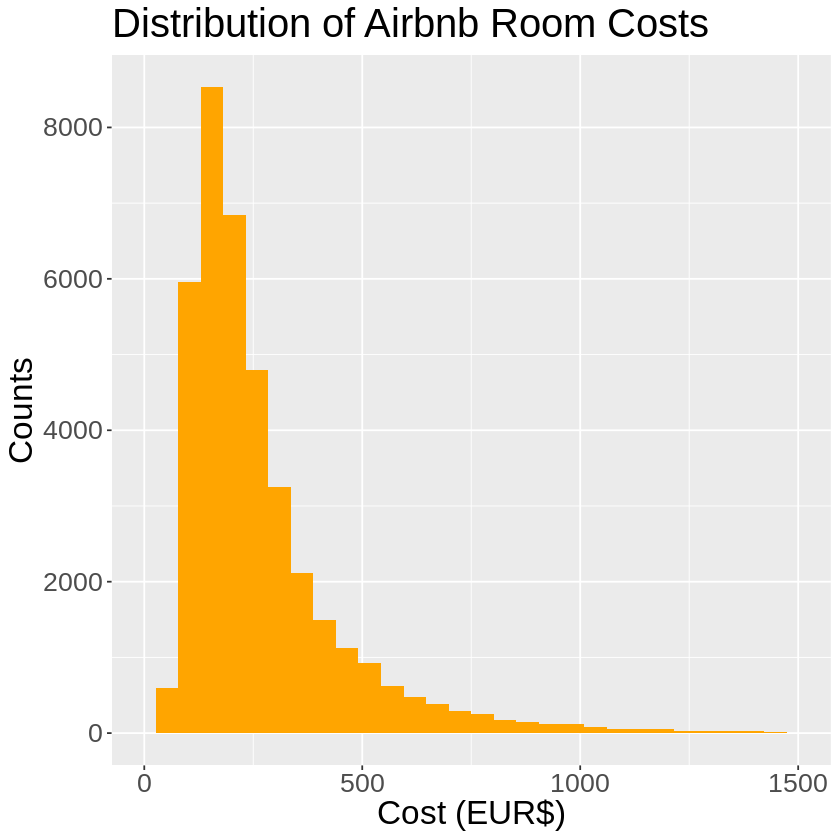

In [16]:
ggplot(airbnb_train, aes(x=cost)) +
    geom_histogram(fill="orange") +
    xlim(0,1500) +
    labs(x="Cost (EUR$)", y="Counts", title="Distribution of Airbnb Room Costs") +
    theme(text = element_text(size = 20))

The distribution of the costs is skewed with a heavy right tail.

## Methods

We are performing multiple linear regression with root mean squared error, predicting the cost of an Airbnb room as we suspect there may be a linear relationship between the explanatory variables such as the distance from city center and the price. Our predictors would be information such as room type, capacity, bedroom count, host information (whether they are a super host or have multiple Airbnb listings if relevant), ratings about the place (cleanliness rating and guest satisfaction), and information about its geographic location (distance from city center, distance to nearest metro, index of the amount of attractions/restaurants nearby).

We are likely not using longitude/latitude for analysis (but potentially used in visualization), and the un-normalized attraction/restaurant index. We are also dropping the dummy variables the dataset has for ‘shared room flag’ and ‘private room flag’.

For visualizing correlations, we can use scatter plots of pairs of variables.

## Expected outcomes and significance:
### What do you expect to find?
We expect to find whether there is a relationship between Airbnb prices in the top cities in Europe and the factors that measure the quality of Airbnb places, including room type, cleanliness, location and other determinants. Furthermore, we hypothesize that there is a strong positive correlation between the Airbnb determinants and the price, and expect to see an increase in price with increased quality of Airbnb determinants such as higher cleanliness, closeness to city centers and metros, having lots of attractions/restaurants nearby and higher guest satisfactions.
### What impact could such findings have?
Travelers will better understand how the specifications, such as cleanliness or attractions, of their accommodation will have an effect on the price of their Airbnb. This will allow travelers to better understand what their budget can offer them and plan their trips accordingly. Airbnb owners can also use these findings to set their prices relative to what other owners are charging depending on the location and other factors of their Airbnb. 
### What future questions could this lead to?
This data only contains the price of the listings, but not the number of people that accept those listings - some future questions could be asking about the relationship or the likelihood of people accepting an Airbnb given these prices and factors.

## References
UNWTO. (January 18, 2023). Number of international tourist arrivals worldwide from 2005 to 
2022, by region (in millions). In Statista. Retrieved March 10, 2023, from https://www.statista.com/statistics/186743/international-tourist-arrivals-worldwide-by-region-since-2010/